# Import Package

In [53]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create DataFrame with Images and Labels

In [54]:
data_path = "/kaggle/input/hieroglyphs/Hieroglyphs Handwriting Alphabet Recognition" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [55]:
data.head()

,image,label
0,/kaggle/input/hieroglyphs/Hieroglyphs Handwrit...,n
1,/kaggle/input/hieroglyphs/Hieroglyphs Handwrit...,n
2,/kaggle/input/hieroglyphs/Hieroglyphs Handwrit...,n
3,/kaggle/input/hieroglyphs/Hieroglyphs Handwrit...,n
4,/kaggle/input/hieroglyphs/Hieroglyphs Handwrit...,n


In [56]:
data.shape

(1288, 2)

In [57]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [58]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (1030, 2)
Validation set shape: (129, 2)
Test set shape: (129, 2)


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1030 validated image filenames belonging to 18 classes.
Found 129 validated image filenames belonging to 18 classes.
Found 129 validated image filenames belonging to 18 classes.


In [60]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'I_capital': 0, 'a': 1, 'b': 2, 'ch': 3, 'f': 4, 'h': 5, 'i': 6, 'k': 7, 'kh': 8, 'n': 9, 'p': 10, 'qu': 11, 'r': 12, 's': 13, 'sh': 14, 't': 15, 'y': 16, 'z': 17}
{'I_capital': 0, 'a': 1, 'b': 2, 'ch': 3, 'f': 4, 'h': 5, 'i': 6, 'k': 7, 'kh': 8, 'n': 9, 'p': 10, 'qu': 11, 'r': 12, 's': 13, 'sh': 14, 't': 15, 'y': 16, 'z': 17}
{'I_capital': 0, 'a': 1, 'b': 2, 'ch': 3, 'f': 4, 'h': 5, 'i': 6, 'k': 7, 'kh': 8, 'n': 9, 'p': 10, 'qu': 11, 'r': 12, 's': 13, 'sh': 14, 't': 15, 'y': 16, 'z': 17}


# Image Visualization

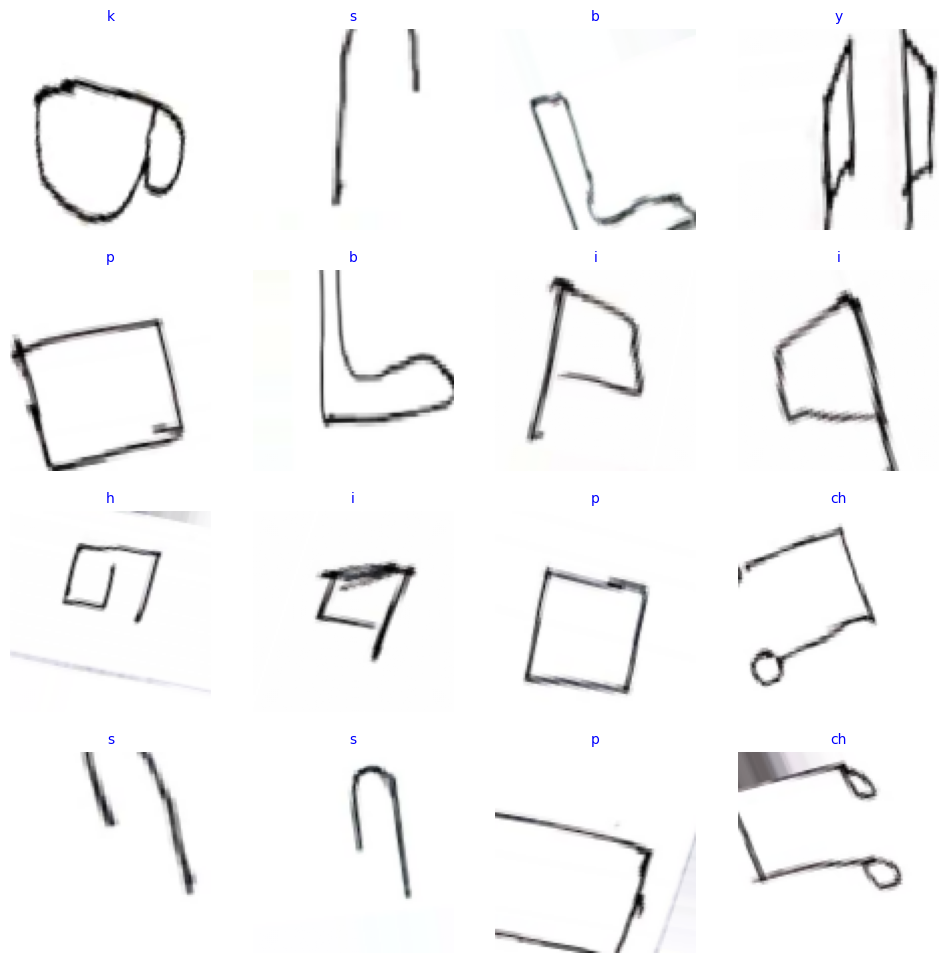

In [61]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

# Callback Function

In [62]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")
            self.model.stop_training = True

# Custom CNN Model

In [63]:
from tensorflow.keras.layers import BatchNormalization


n_classes = 18
input_shape = (100, 100, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))



model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,218 (1.92 MB)

 Trainable params: 502,514 (1.92 MB)

 Non-trainable params: 704 (2.75 KB)

In [64]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=200,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/200
Epoch 1: Training accuracy is 0.1311
Epoch 1: Validation accuracy is 0.0388
33/33 - 13s - 386ms/step - accuracy: 0.1311 - loss: 4.3591 - val_accuracy: 0.0388 - val_loss: 9.1117 - learning_rate: 9.0484e-04
Epoch 2/200
Epoch 2: Training accuracy is 0.2777
Epoch 2: Validation accuracy is 0.0543
33/33 - 4s - 115ms/step - accuracy: 0.2777 - loss: 3.8531 - val_accuracy: 0.0543 - val_loss: 5.8102 - learning_rate: 8.1873e-04
Epoch 3/200
Epoch 3: Training accuracy is 0.3883
Epoch 3: Validation accuracy is 0.1705
33/33 - 4s - 115ms/step - accuracy: 0.3883 - loss: 3.4875 - val_accuracy: 0.1705 - val_loss: 4.8478 - learning_rate: 7.4082e-04
Epoch 4/200
Epoch 4: Training accuracy is 0.4670
Epoch 4: Validation accuracy is 0.2403
33/33 - 4s - 110ms/step - accuracy: 0.4670 - loss: 3.1811 - val_accuracy: 0.2403 - val_loss: 3.8461 - learning_rate: 6.7032e-04
Epoch 5/200
Epoch 5: Training accuracy is 0.5330
Epoch 5: Validation accuracy is 0.3411
33/33 - 4s - 110ms/step - accuracy: 0.5330 - lo

# Accuracy and Loss Curve

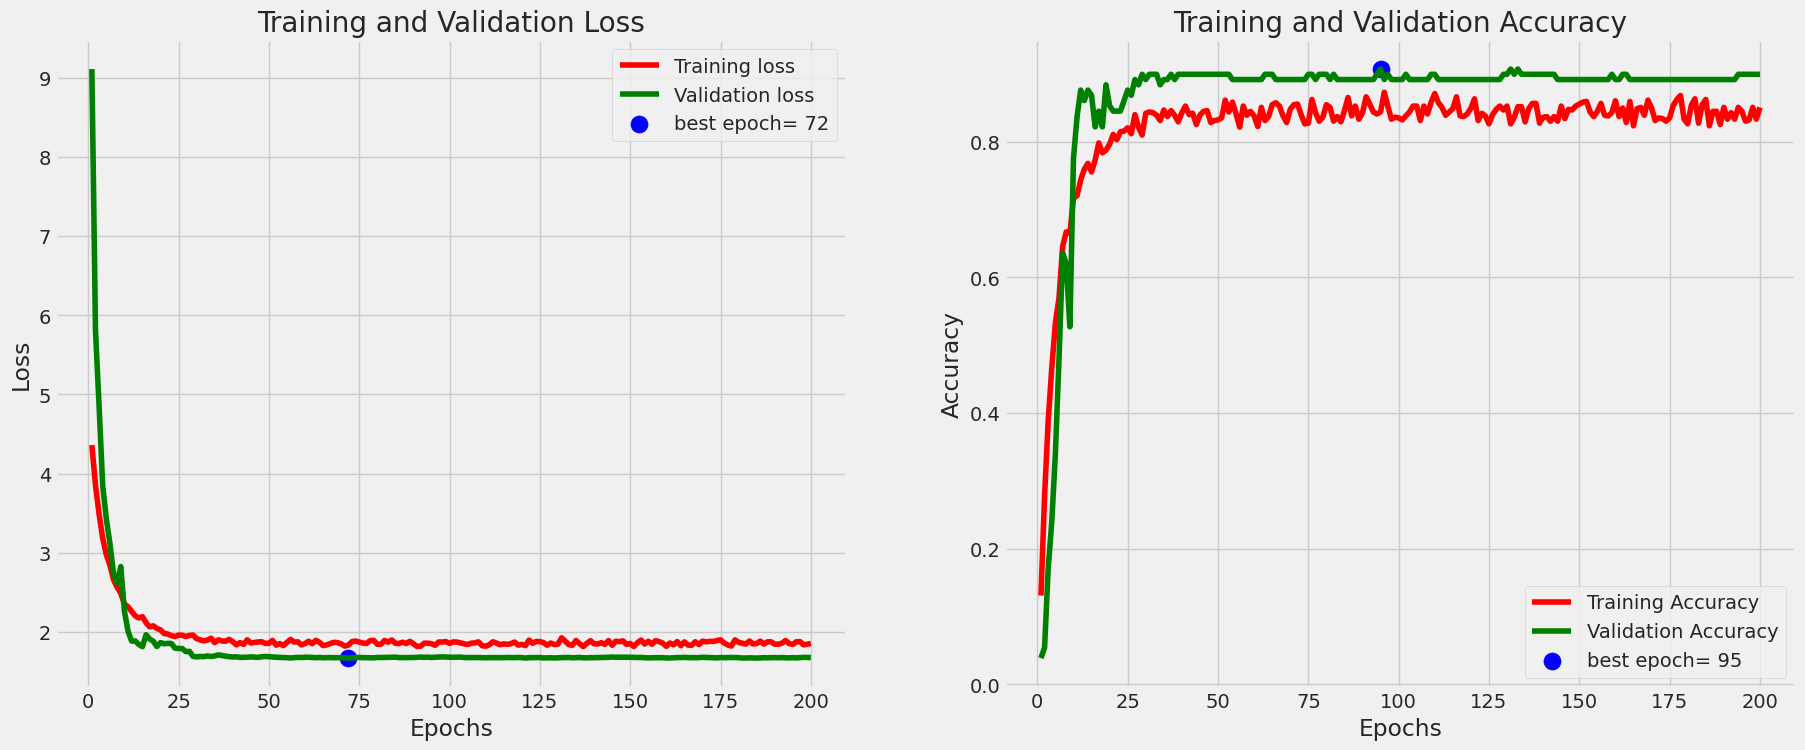

In [66]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()


# Accuracy

In [67]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9148 - loss: 1.6588
Accuracy score: 0.8992248177528381


In [68]:
model.save('model_8992.h5')


In [69]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8801 - loss: 1.6428 
Test accuracy: 0.8682
Test loss: 1.6833


In [70]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8216 - loss: 1.8462
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9271 - loss: 1.6533
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8932 - loss: 1.6006
Train Loss:  1.7632102966308594
Train Accuracy:  0.8541666865348816
--------------------
Valid Loss:  1.679521918296814
Valid Accuracy:  0.9166666865348816
--------------------
Test Loss:  1.5986324548721313
Test Accuracy:  0.8958333134651184


# Classification Report


In [71]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

print(classification_report(test_gen.classes, y_pred, target_names= classes))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
              precision    recall  f1-score   support

   I_capital       0.62      0.83      0.71         6
           a       1.00      1.00      1.00         5
           b       1.00      1.00      1.00         7
          ch       1.00      0.57      0.73         7
           f       0.78      1.00      0.88         7
           h       0.83      1.00      0.91        15
           i       0.70      1.00      0.82         7
           k       1.00      1.00      1.00         7
          kh       1.00      0.57      0.73         7
           n       1.00      1.00      1.00         7
           p       0.73      1.00      0.84         8
          qu       1.00      0.71      0.83         7
           r       1.00      0.57      0.73         7
           s       1.00      0.17      0.29         6
          sh       1.00      1.00      1.00         6
           t       0.70      1.00      0.82         7
           y       1.00      1.00      1.0

# Display image from each of the class

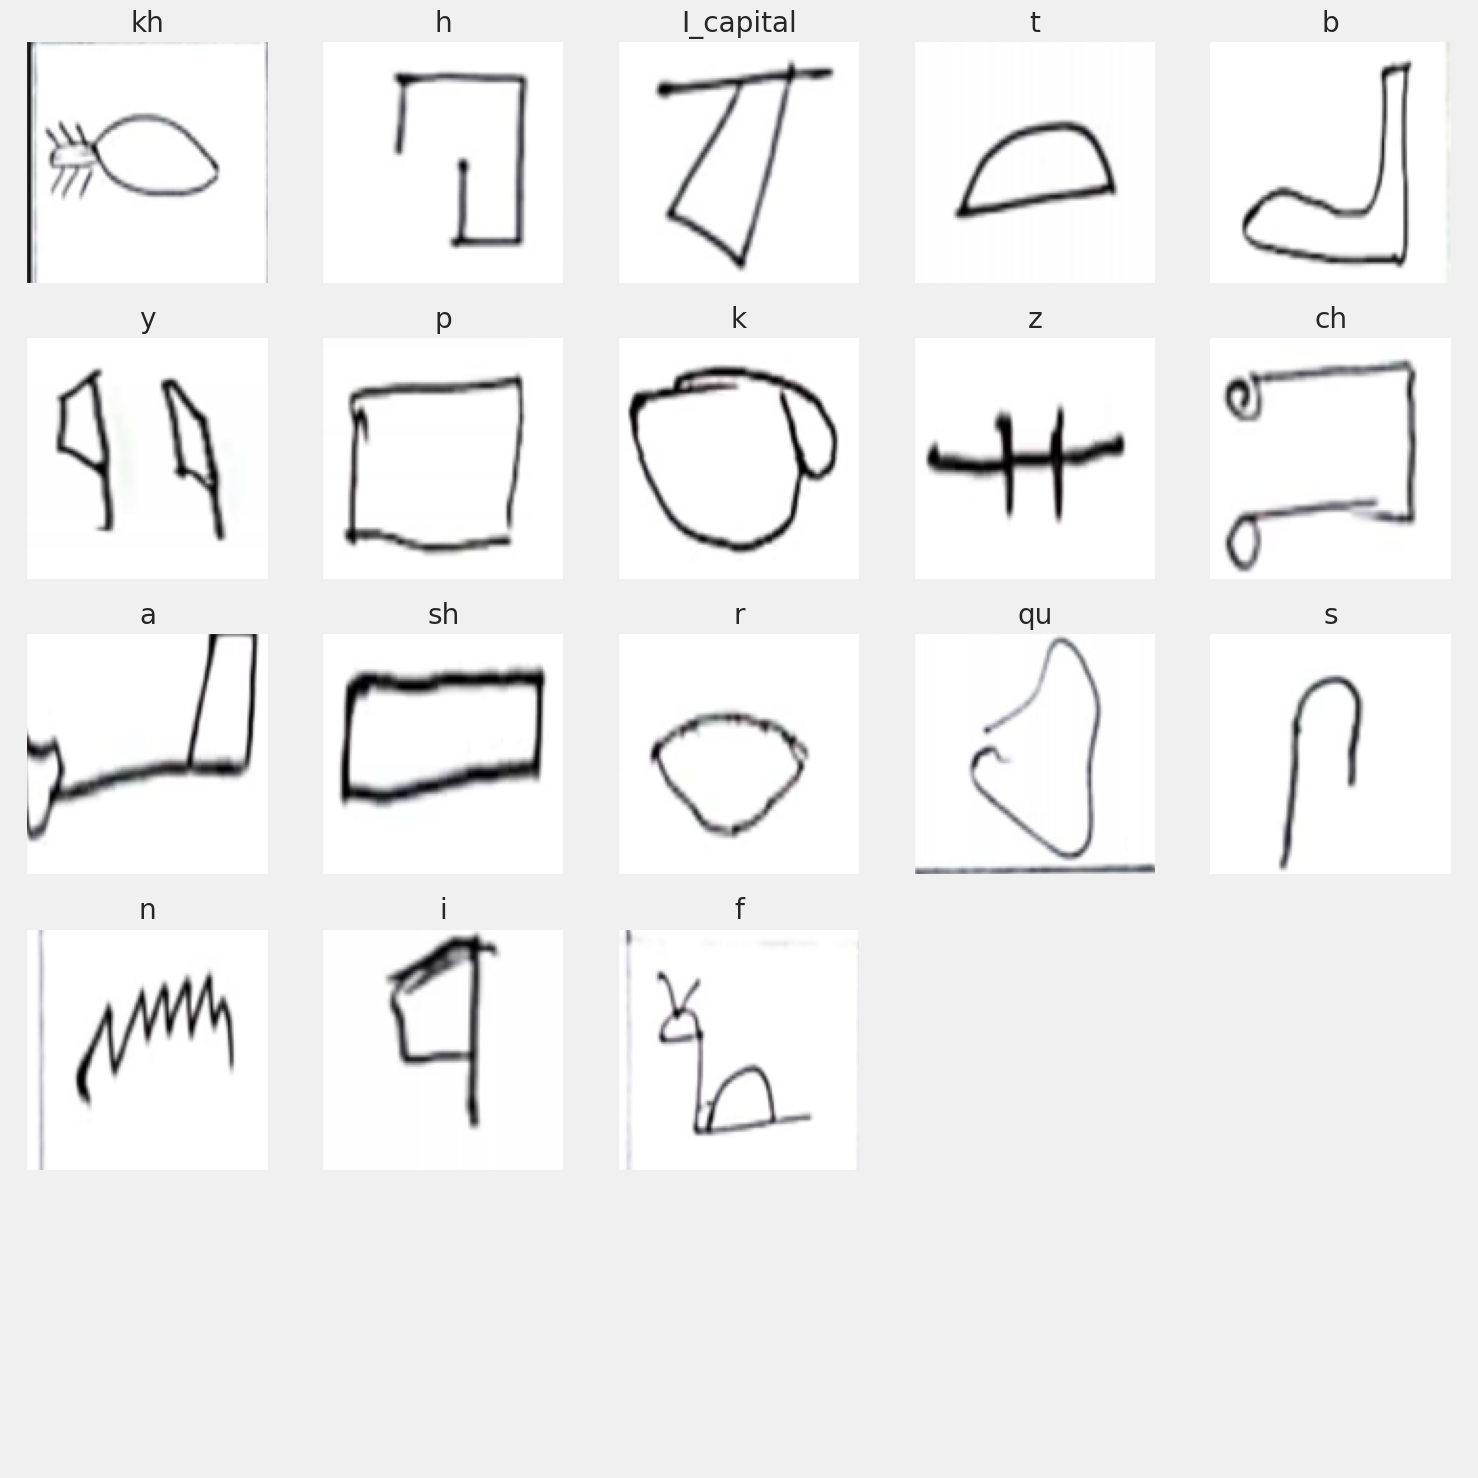

In [76]:
import matplotlib.pyplot as plt
from PIL import Image

class_samples = []

for label in test_df['label'].unique():
    sample = test_df[test_df['label'] == label].iloc[0]  
    class_samples.append((sample['image'], sample['label']))

target_size = (128, 128)  

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for idx, (filepath, label) in enumerate(class_samples):
    row, col = divmod(idx, 5)  
    ax = axes[row, col]  
    img = Image.open(filepath)
    img_resized = img.resize(target_size)
    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('Display_images.jpg', dpi=1200)
plt.show()


# Confusion Matrix

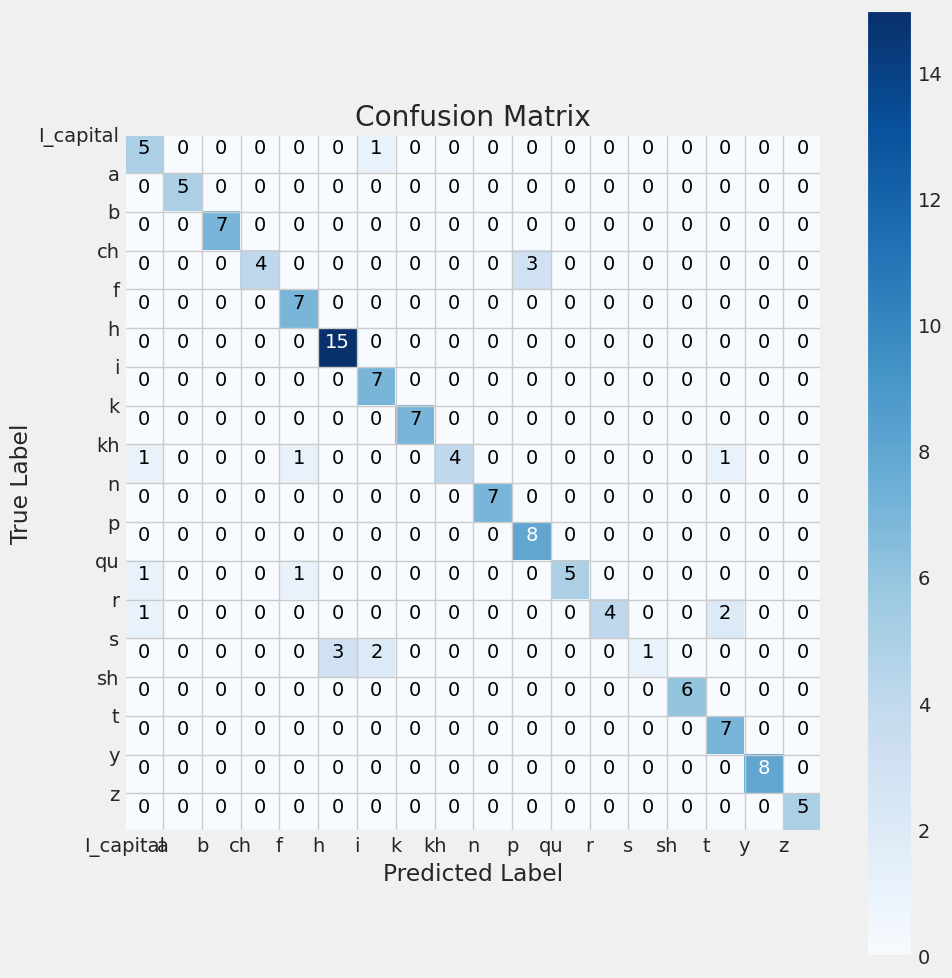

In [77]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


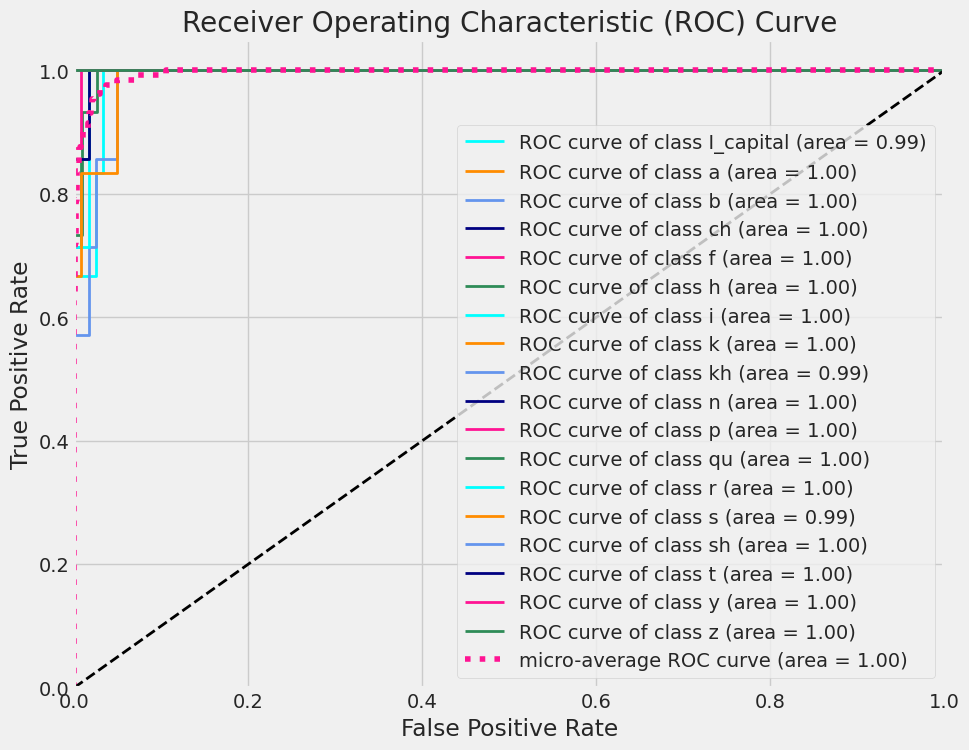

In [78]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

# AUC Score

In [79]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class I_capital: 0.99
AUC for class a: 1.00
AUC for class b: 1.00
AUC for class ch: 1.00
AUC for class f: 1.00
AUC for class h: 1.00
AUC for class i: 1.00
AUC for class k: 1.00
AUC for class kh: 0.99
AUC for class n: 1.00
AUC for class p: 1.00
AUC for class qu: 1.00
AUC for class r: 1.00
AUC for class s: 0.99
AUC for class sh: 1.00
AUC for class t: 1.00
AUC for class y: 1.00
AUC for class z: 1.00
Micro-average AUC: 1.00
Macro-average AUC: 1.00
